<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/multi_agentic_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This textbook consist of multi agentic system

## In this first problem we will see how to agents communicate with each other to perfom multiplication and the Addition.In this problem statement there will be two agent, one good in  mulitplication and other good in addition there task will be to communicate with each other resembling how the network multiagents system communicate

In [ ]:
pip install langchain langgraph langchain-core langchain-groq

In [53]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')

In [54]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from typing import Literal

In [55]:
llm=ChatGroq(model="openai/gpt-oss-120b",api_key=api_key)

In [56]:
llm.invoke("HI")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user just says "HI". Probably respond with a greeting. Should ask how can I help.'}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 72, 'total_tokens': 111, 'completion_time': 0.080408682, 'completion_tokens_details': {'reasoning_tokens': 21}, 'prompt_time': 0.003005557, 'prompt_tokens_details': None, 'queue_time': 0.067459488, 'total_time': 0.083414239}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_c868cf1eaa', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2256-5f53-73f0-8e04-cf461a2d61ba-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 72, 'output_tokens': 39, 'total_tokens': 111, 'output_token_details': {'reasoning': 21}})

In [80]:
@tool
def transfer_to_multiplication_agent():
  """Ask multiplication_expert_agent for help"""
  return

@tool
def transfer_to_addition_agent():
  """Ask addition_expert_agent for help"""
  return



In [102]:
def addition_expert_agent(state:MessagesState)->Command[Literal["multiplication_agent","__end__"]]:
  system_prompt=("You are an addition expert, you can ask the mutiplication_expert_agent for help with multiplication."
                  "Always do you portion of calculation i.e addition before asking help from multiplication_expert_agent"

  )
  messages=[{"role":"system","content":system_prompt}]+state["messages"]
  ai_msg=llm.bind_tools([transfer_to_multiplication_agent]).invoke(messages)
  if len(ai_msg.tool_calls)>0:
    tool_call_id=ai_msg.tool_calls[-1]["id"]
    tool_msg={
        "role":"tool",
        "content":"sucessfully transferred to multiplication agent",
        "tool_call_id":tool_call_id
    }
    return Command(goto="multiplication_agent",update={"messages":[ai_msg,tool_msg]})
  else:
    return Command(goto="__end__",update={"messages":[ai_msg]})



In [109]:
def multiplication_expert_agent(state:MessagesState)->Command[Literal["addition_agent","__end__"]]:
  system_prompt=("You are an multiplication expert, you can ask the addition_expert_agent for help with multiplication."
  "Always do you portion of calculation i.e multiplication before asking help from addition_expert_agent."

  )
  messages=[{"role":"system","content":system_prompt}]+state["messages"]
  ai_msg=llm.bind_tools([transfer_to_addition_agent]).invoke(messages)
  if len(ai_msg.tool_calls)>0:
    tool_call_id=ai_msg.tool_calls[-1]["id"]
    tool_msg={
        "role":"tool",
        "content":"sucessfully transferred to addition agent",
        "tool_call_id":tool_call_id
    }
    return Command(goto="addition_agent",update={"messages":[ai_msg,tool_msg]})
  else:
    return Command(goto="__end__",update={"messages":[ai_msg]})

In [110]:
workflow=StateGraph(MessagesState)
workflow.add_node("multiplication_agent",multiplication_expert_agent)
workflow.add_node("addition_agent",addition_expert_agent)
workflow.add_edge(START,"multiplication_agent")

In [111]:
app=workflow.compile()

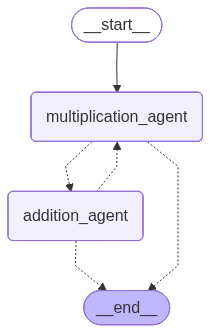

In [112]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [119]:
events=app.stream({"messages":"what is 2*3+4"},stream_mode="values")
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

what is 2*3+4
================================= Tool Message =================================

sucessfully transferred to addition agent
================================= Tool Message =================================

sucessfully transferred to multiplication agent
================================= Tool Message =================================

sucessfully transferred to addition agent
================================== Ai Message ==================================

First, we need the product \(2 \times 3\).  
The multiplication expert would give us \(6\).  

Now we add the remaining term:

\[
6 + 4 = 10.
\]

So \(2 \times 3 + 4 = \boxed{10}\).


### Now time to do capstone project that consist of the two agent one who do research and another one who will create graph. For research we will use the Tavilysearch and for the chart we use python repl tool

In [1]:
pip install langchain langgraph tavily-python langchain-groq langchain-community langchain-tavily langchain-experimental langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.8/495.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.7
    Uninstalling langchain-core-1.2.7:
      Successfully uninstalled langchain-core-1.2.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

In [2]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')
tavily_api_key=userdata.get('Tavily_api_key')

In [4]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_tavily import TavilySearch
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from typing import Annotated, Literal
from langgraph.types import Command
from langchain_groq import ChatGroq

In [8]:
llm=ChatGroq(model="openai/gpt-oss-120b", api_key=api_key)
search_tool=TavilySearch(tavily_api_key=tavily_api_key)
repl=PythonREPL()


In [10]:
@tool
def python_repl_tool(code:Annotated[str,"The python code to generate your chart"]):
  """Use this to execute python code.If you want to see the output of a value, you should print it out with `print(...)`.This is visible to the user."""
  try:
    result=repl.run(code)
  except Exception as e:
    return f"Failed to Execute error"
  result_str=f"Sucessfully executed:\n\`\`\`python\n{code}\n\`\`\`\n Stdout:{result}"
  return(
      result_str+ "\n\n If you have completed all tasks respond with FINAL ANSWER."
  )

<>:8: SyntaxWarning: invalid escape sequence '\`'
<>:8: SyntaxWarning: invalid escape sequence '\`'
<>:8: SyntaxWarning: invalid escape sequence '\`'
<>:8: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipython-input-284795218.py:8: SyntaxWarning: invalid escape sequence '\`'
  result_str=f"Sucessfully executed:\n\`\`\`python\n{code}\n\`\`\`\n Stdout:{result}"
/tmp/ipython-input-284795218.py:8: SyntaxWarning: invalid escape sequence '\`'
  result_str=f"Sucessfully executed:\n\`\`\`python\n{code}\n\`\`\`\n Stdout:{result}"


In [12]:
def make_system_prompt(instruction:str)->str:
  return (
      "You are helpful AI Assitant, Collaborating with other assistants."
      "If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off. Execute what you can to make progress."
      "If you or any of te other, assistants have the final answer or deliverable , prefix your response with FINAL ANSWER so the team knows to stop."
      f"\n {instruction}"
  )

In [14]:
def get_next_node(last_message:BaseMessage, goto:str):
  if "FINAL ANSWER" in last_message.content:
    return END
  else:
    return goto

In [15]:
research_agent=create_react_agent(
    llm,
    tools=[search_tool],
    prompt=make_system_prompt("You can only do research. You are working with a chart generator colleague")
)

/tmp/ipython-input-3527778222.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent=create_react_agent(


In [16]:
chart_agent=create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt("You can only generate chart.You are working iwth researcher colleague")
)

/tmp/ipython-input-876269490.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_agent=create_react_agent(


In [18]:
def research_node(state:MessagesState)->Command[Literal["chart_generator",END]]:
  result=research_agent.invoke(state)
  goto=get_next_node(result["messages"][-1],"chart-generator")
  result["messages"][-1]=HumanMessage(content=result["messages"][-1].content,name="researcher")
  return Command(
      update={"messages":[result["messages"]]},
      goto=goto
  )

In [19]:
def chart_node(state:MessagesState)->Command[Literal["chart_generator",END]]:
  result=chart_agent.invoke(state)
  goto=get_next_node(result["messages"][-1],"chart-generator")
  result["messages"][-1]=HumanMessage(content=result["messages"][-1].content,name="chart_generator")
  return Command(
      update={"messages":[result["messages"]]},
      goto=goto
  )